The business problem addresses here relates to marketing.
The dataset provided is derived from the telephone marketing efforts of a Portuguese bank. The specific prediction problem is to determine whether a customer will agree to a term deposit.

In [ ]:
# !pip install ucimlrepo # Google Colab-specific syntax

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [5]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

numeric_transformer = StandardScaler()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

from sklearn.pipeline import Pipeline

pipelines = {
    "KNN": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]),
    "SVM": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True))
    ])
}

results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    if hasattr(pipeline['classifier'], 'predict_proba'):
        probability = pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, probability)
        results[name] = {
            "classification_report": classification_report(y_test, predictions),
            "AUC": auc_score,
            "probability": probability
        }
    else:
        results[name] = {
            "classification_report": classification_report(y_test, predictions),
            "AUC": 'N/A'
        }

for name, result in results.items():
    print(f"{name} Classifier:")
    print("AUC:", result.get('AUC', 'N/A'))
    print(result['classification_report'])


KNN Classifier:
AUC: 0.825050565672409
              precision    recall  f1-score   support

          no       0.92      0.97      0.94     11966
         yes       0.60      0.34      0.44      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.66      0.69     13564
weighted avg       0.88      0.90      0.88     13564

Logistic Regression Classifier:
AUC: 0.9005212306792482
              precision    recall  f1-score   support

          no       0.92      0.97      0.94     11966
         yes       0.63      0.33      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564

Decision Tree Classifier:
AUC: 0.6886137234471387
              precision    recall  f1-score   support

          no       0.93      0.92      0.93     11966
         yes       0.45      0.45      0.45      1598

    accuracy                         

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


Age Distribution

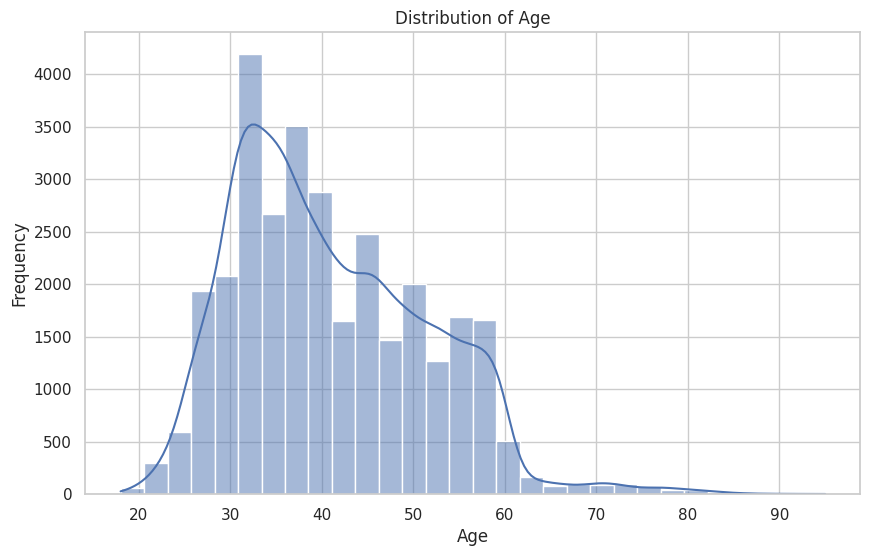

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train, x='age', bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


Job Type

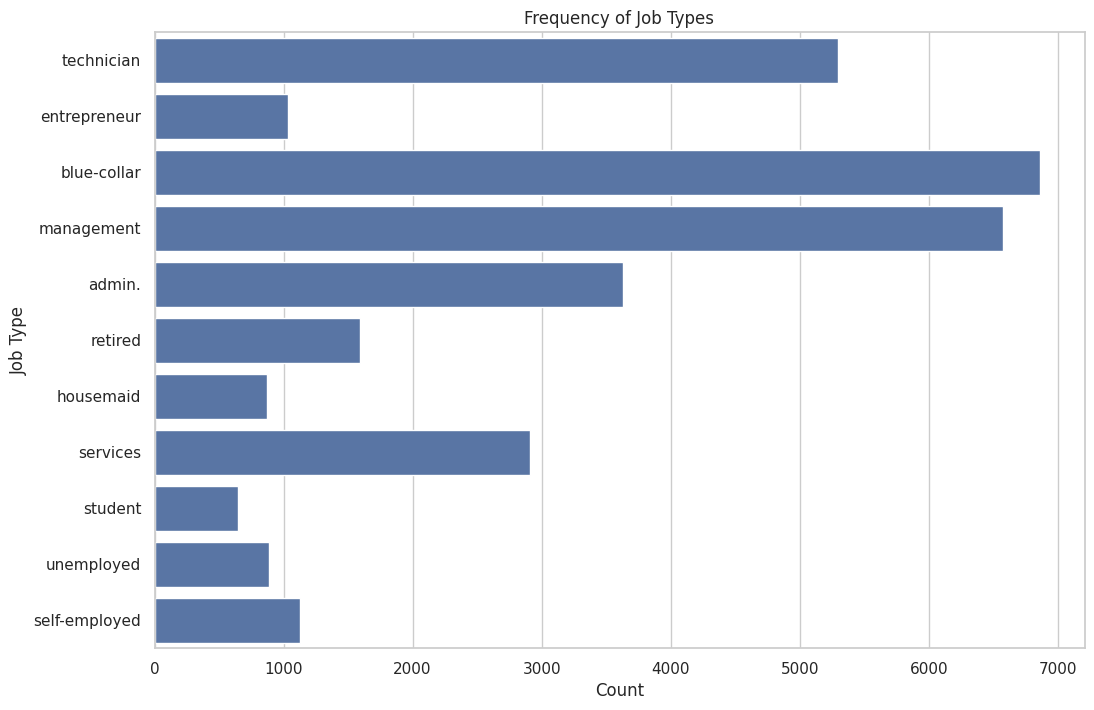

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(data=X_train, y='job')
plt.title('Frequency of Job Types')
plt.xlabel('Count')
plt.ylabel('Job Type')
plt.show()


Subscription Rate By Month

<ipython-input-25-cabee6044964>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subscription_rate_by_month.index, y=subscription_rate_by_month.values, palette='viridis')


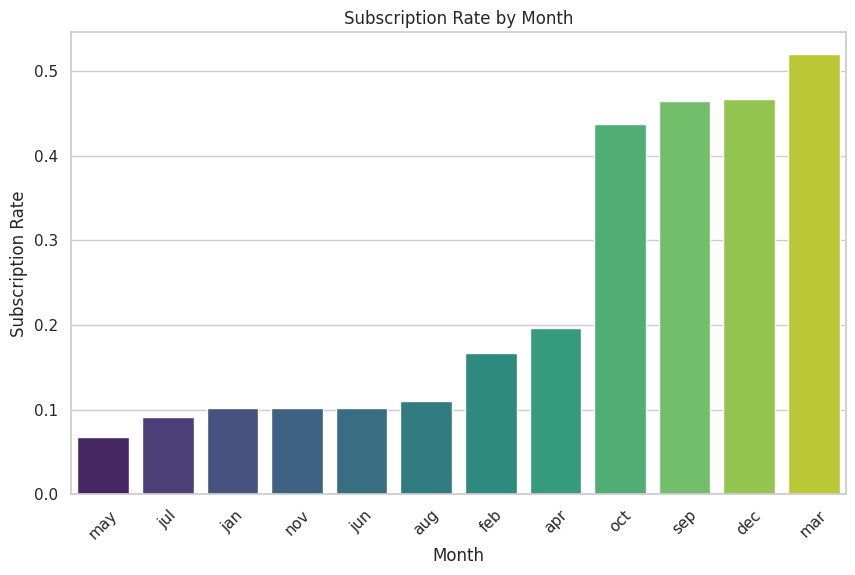

In [25]:
data = pd.DataFrame({
    'month': bank_marketing.data.features['month'],
    'y': bank_marketing.data.targets.squeeze()
})

# 'yes'/'no' => 1/0
data['subscribed'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

subscription_rate_by_month = data.groupby('month')['subscribed'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=subscription_rate_by_month.index, y=subscription_rate_by_month.values, palette='viridis')
plt.title('Subscription Rate by Month')
plt.xlabel('Month')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.show()


Account Balance

Correlation Matrix

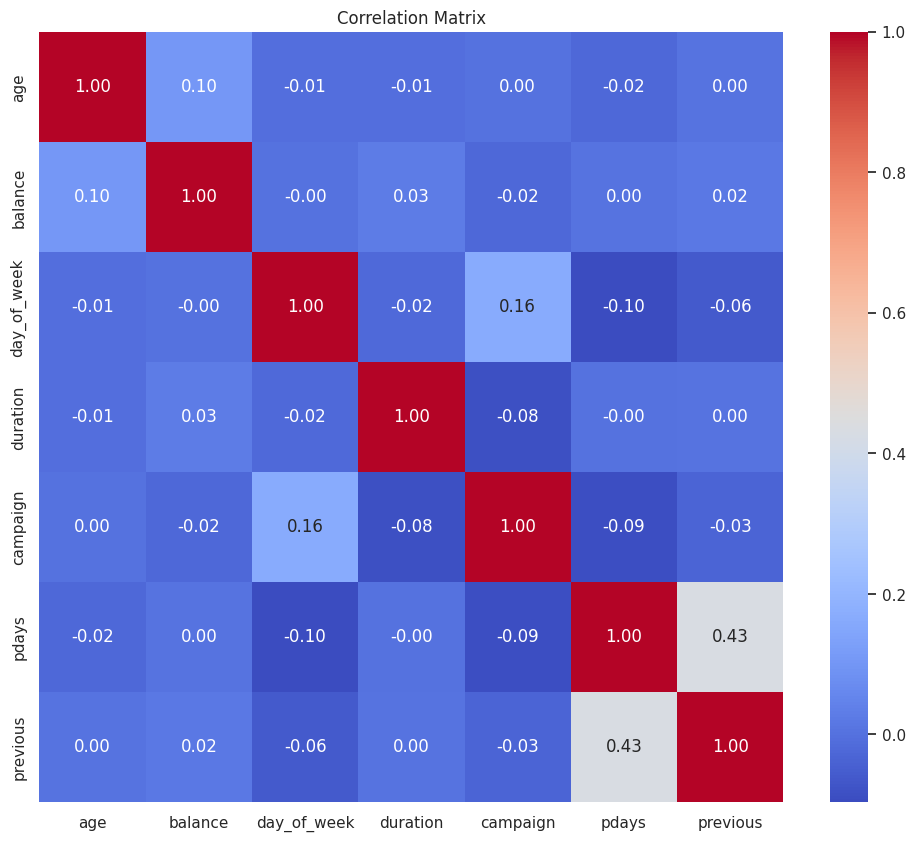

In [14]:
plt.figure(figsize=(12, 10))
corr = X_train[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


ROC Curve

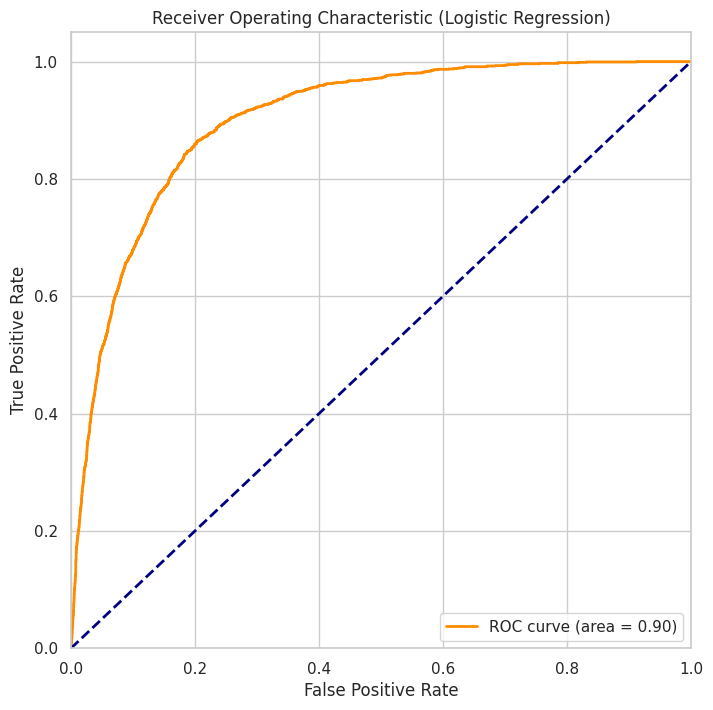

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

fpr, tpr, _ = roc_curve(y_test_encoded, results['Logistic Regression']['probability'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()


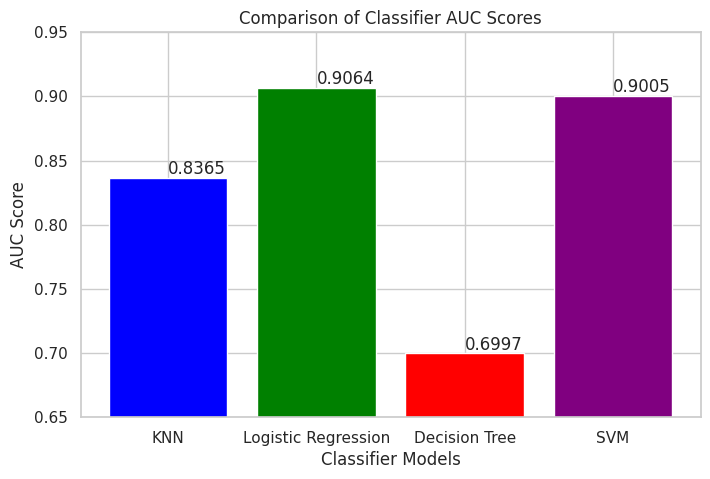

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# AUC scores
models = ['KNN', 'Logistic Regression', 'Decision Tree', 'SVM']
auc_scores = [0.8365, 0.9064, 0.6997, 0.9005]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(models, auc_scores, color=['blue', 'green', 'red', 'purple'])

ax.set_xlabel('Classifier Models')
ax.set_ylabel('AUC Score')
ax.set_title('Comparison of Classifier AUC Scores')
ax.set_ylim(0.65, 0.95)

# labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')

plt.show()


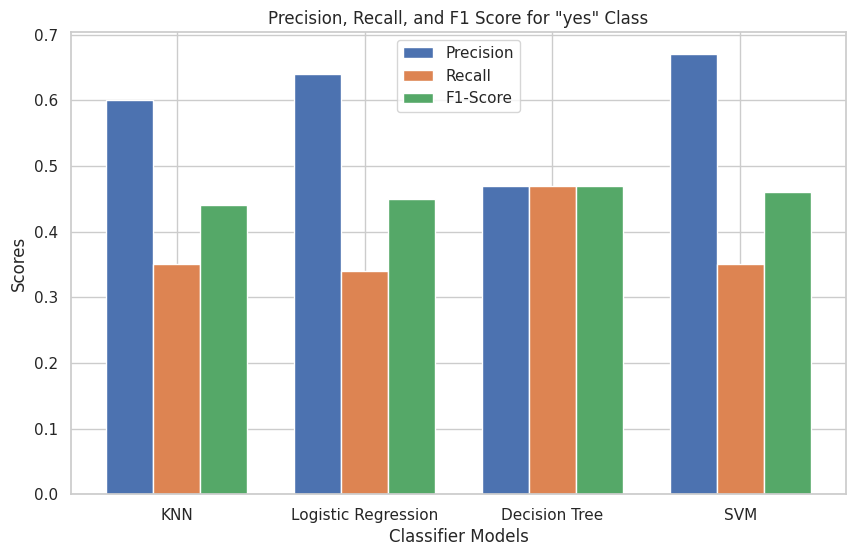

In [22]:
# scores for yes's
precision_scores = [0.60, 0.64, 0.47, 0.67]
recall_scores = [0.35, 0.34, 0.47, 0.35]
f1_scores = [0.44, 0.45, 0.47, 0.46]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1-Score')

ax.set_xlabel('Classifier Models')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for "yes" Class')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


In [23]:
# examine model feature contributions
logreg_pipeline = pipelines['Logistic Regression']
logreg_classifier = logreg_pipeline.named_steps['classifier']

coefficients = logreg_classifier.coef_[0]

feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()

import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# sort
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
important_features = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

print(important_features.head(10))


                  Feature  Coefficient  Absolute Coefficient
39         cat__month_mar     1.580064              1.580064
46  cat__poutcome_success     1.531951              1.531951
3           num__duration     1.062479              1.062479
36         cat__month_jan    -0.988013              0.988013
42         cat__month_oct     0.970744              0.970744
44  cat__poutcome_failure    -0.929725              0.929725
40         cat__month_may    -0.842391              0.842391
43         cat__month_sep     0.825691              0.825691
34         cat__month_dec     0.643052              0.643052
37         cat__month_jul    -0.638495              0.638495
